In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import brown, stopwords

In [3]:
# import corpus here
# nltk.download() 

In [4]:
print(brown.categories())


['adventure', 'belles_lettres', 'editorial', 'fiction', 'government', 'hobbies', 'humor', 'learned', 'lore', 'mystery', 'news', 'religion', 'reviews', 'romance', 'science_fiction']


## I am using only 5 of the categories from the Brown corpus to keep my total amount of data low enough to work on my local machine. 

In [5]:
raw_adventure = brown.sents(categories='adventure')
raw_lore = brown.sents(categories='lore')
raw_mystery = brown.sents(categories='mystery')
raw_romance = brown.sents(categories='romance')
raw_science_fiction = brown.sents(categories='science_fiction')



In [6]:
print(len(raw_adventure))
print(len(raw_lore))
print(len(raw_mystery))
print(len(raw_romance))
print(len(raw_science_fiction))

4637
4881
3886
4431
948


### I am dropping the science fiction label because of the drastic difference in length.

In [7]:
joined_adventure = [" ".join(sent) for sent in raw_adventure]
joined_lore = [" ".join(sent) for sent in raw_lore]
joined_mystery = [" ".join(sent) for sent in raw_mystery]
joined_romance = [" ".join(sent) for sent in raw_romance]


In [9]:
from string import punctuation
table = str.maketrans({key:None for key in punctuation})
cleaned_adventure = [sent.translate(table) for sent in joined_adventure]
cleaned_lore = [sent.translate(table) for sent in joined_lore]
cleaned_mystery = [sent.translate(table) for sent in joined_mystery]
cleaned_romance = [sent.translate(table) for sent in joined_romance]


In [10]:
cleaned_adventure[0]

'Dan Morgan told himself he would forget Ann Turner '

In [11]:
adventure_sents = [[sent, "adventure"] for sent in cleaned_adventure]
lore_sents = [[sent, "lore"] for sent in cleaned_lore]
mystery_sents = [[sent, "mystery"] for sent in cleaned_mystery]
romance_sents = [[sent, "romance"] for sent in cleaned_romance]

sentences = pd.DataFrame(adventure_sents +
                         lore_sents +
                         mystery_sents +
                         romance_sents)
sentences.head()

,0,1
0,Dan Morgan told himself he would forget Ann Tu...,adventure
1,He was well rid of her,adventure
2,He certainly didnt want a wife who was fickle ...,adventure
3,If he had married her hed have been asking fo...,adventure
4,But all of this was rationalization,adventure


In [12]:
nlp = spacy.load('en')

In [13]:
from collections import Counter

In [14]:
# Utility function to create a list of the 3000 most common words.
# changed word cound from 2000 to 200 because we aren't comparing works from
# two different authors but from 5 different genres.

def bag_of_words(text):
    
    # make text string, pull out each word
    text = str(text)
    allwords = text.split()
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(200)]
    

def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        sentence = nlp(sentence)
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 1000 == 0:
            print("Processing row {}".format(i))
            
    return df


In [15]:
adventure_words = bag_of_words(cleaned_adventure)
print(len(adventure_words))


200


In [16]:
lore_words = bag_of_words(cleaned_lore)
mystery_words = bag_of_words(cleaned_mystery)
romance_words = bag_of_words(cleaned_romance)

common_words = set(adventure_words +
                   lore_words +
                   mystery_words +
                   romance_words)

len(common_words)

296

In [17]:
word_counts = bow_features(sentences, common_words)

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
Processing row 5000
Processing row 6000
Processing row 7000
Processing row 8000
Processing row 9000
Processing row 10000
Processing row 11000
Processing row 12000
Processing row 13000
Processing row 14000
Processing row 15000
Processing row 16000
Processing row 17000


# make tf-idf df

### I am combining the texts all together before splitting the paragraphs apart because I cannot feed them to the vectorizer if I join them after splitting.

In [18]:
# combine the texts then split into paragraphs
adventure = brown.raw(categories='adventure')
lore = brown.raw(categories='lore')
mystery = brown.raw(categories='mystery')
romance = brown.raw(categories='romance')

combined2 = adventure + lore + mystery + romance
combined2 = combined2.split('\n\n\n\t')
combined2[0]

"\n\n\tDan/np Morgan/np told/vbd himself/ppl he/pps would/md forget/vb Ann/np Turner/np ./.\nHe/pps was/bedz well/rb rid/jj of/in her/ppo ./.\nHe/pps certainly/rb didn't/dod* want/vb a/at wife/nn who/wps was/bedz fickle/jj as/cs Ann/np ./.\nIf/cs he/pps had/hvd married/vbn her/ppo ,/, he'd/pps+md have/hv been/ben asking/vbg for/in trouble/nn ./."

In [19]:
print('length combined2: ', len(combined2))
print('length adventure: ', len(adventure.split('\n\n\n\t')))
print('length lore: ', len(lore.split('\n\n\n\t')))
print('length mystery: ', len(mystery.split('\n\n\n\t')))
print('length romance: ', len(romance.split('\n\n\n\t')))

print('adventure indicies should end at:', len(adventure.split('\n\n\n\t')))
print('lore indicies should end at: ', len((adventure + lore).split('\n\n\n\t')))
print('mystery indicies should end at: ', len((adventure + lore + mystery).split('\n\n\n\t')))
print('romance indicies should end at:', len((adventure + lore + mystery + romance).split('\n\n\n\t')))


length combined2:  4579
length adventure:  1303
length lore:  1042
length mystery:  1080
length romance:  1154
adventure indicies should end at: 1303
lore indicies should end at:  2345
mystery indicies should end at:  3425
romance indicies should end at: 4579


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.75, 
                             min_df=2,
                             lowercase=False,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True)


# Applying the vectorizer
brown_paras_tfidf=vectorizer.fit_transform(combined2)
print("Number of features: %d" % brown_paras_tfidf.get_shape()[1])



Number of features: 11652


In [21]:
brown_paras_tfidf.get_shape()

(4579, 11652)

In [22]:
feature_names = (vectorizer.vocabulary_)
feature_sorted = sorted(feature_names, key = feature_names.get)

In [23]:
vectorized_df = pd.DataFrame(data=brown_paras_tfidf.toarray(),
                             index=np.arange(brown_paras_tfidf.shape[0]),
                             columns=(feature_sorted))

In [24]:
vectorized_df['categories'] = None
vectorized_df.loc[0:1303, 'categories'] = 'adventure'
vectorized_df.loc[1303:2345, 'categories'] = 'lore'
vectorized_df.loc[2345:3425, 'categories'] = 'mystery'
vectorized_df.loc[3425:4579, 'categories'] = 'romance'

## modeling section

In [25]:
# Set up pipeline here
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
lr = LogisticRegression()

svd= TruncatedSVD(200)
logr_pipe = make_pipeline(svd, lr)
forest_pipe = make_pipeline(svd, rfc)


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Bag-Of-Words supervised learning

word_count_Y = word_counts['text_source']
word_count_X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(word_count_X, 
                                                    word_count_Y,
                                                    test_size=0.4)
train = forest_pipe.fit(X_train, y_train)

print('Training set score:', forest_pipe.score(X_train, y_train))
print('\nTest set score:', forest_pipe.score(X_test, y_test))

Training set score: 0.9057097467526399

Test set score: 0.3523969722455845


In [27]:
print('Random Forest Train:')
cross_val_score(forest_pipe, X_train, y_train)


Random Forest Train:


array([0.34753363, 0.33548206, 0.3430575 ])

In [28]:
print('Random Forest Test:')
cross_val_score(forest_pipe, X_test, y_test)


Random Forest Test:


array([0.34705882, 0.33515559, 0.33922559])

In [29]:
# Word Count Model
train = logr_pipe.fit(X_train, y_train)
print('Training set score:', logr_pipe.score(X_train, y_train))
print('\nTest set score:', logr_pipe.score(X_test, y_test))
print('\nCross Validation:', cross_val_score(logr_pipe, X_test, y_test))

Training set score: 0.4541631623212784

Test set score: 0.4349593495934959

Cross Validation: [0.43361345 0.43187553 0.42887205]


In [30]:
# TF-IDF variable set up and split

tfidf_X = vectorized_df.drop(labels='categories', axis=1)
tfidf_y = vectorized_df.categories

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_X,
                                                                            tfidf_y,
                                                                            test_size=0.4)


In [31]:
# TF-IDF Model
train = logr_pipe.fit(X_train_tfidf, y_train_tfidf)
print(X_train_tfidf.shape, y_train_tfidf.shape)
print('TFIDF Training set score:', logr_pipe.score(X_train_tfidf, y_train_tfidf))
print('\n TFIDF Test set score:', logr_pipe.score(X_test_tfidf, y_test_tfidf))
print('\nCross Validation', cross_val_score(logr_pipe, X_test_tfidf, y_test_tfidf))

train = forest_pipe.fit(X_train_tfidf, y_train_tfidf)
print('TFIDF Training set score:', forest_pipe.score(X_train_tfidf, y_train_tfidf))
print('\nTFIDF Test set score:', forest_pipe.score(X_test_tfidf, y_test_tfidf))
print('\nCross Validation', cross_val_score(forest_pipe, X_test_tfidf, y_test_tfidf))

(2747, 11651) (2747,)
TFIDF Training set score: 0.6701856570804514

 TFIDF Test set score: 0.5835152838427947

Cross Validation [0.55065359 0.5695581  0.55993432]
TFIDF Training set score: 0.9916272297051328

TFIDF Test set score: 0.44541484716157204

Cross Validation [0.44771242 0.44517185 0.46633826]


### I am upping the number of estimators in the random forest classifier to 100 from the default 10 to  attempt to improve performance

In [33]:
rfc2 = ensemble.RandomForestClassifier(n_estimators=100)
forest_pipe2 = make_pipeline(svd, rfc2)
train = forest_pipe2.fit(X_train_tfidf, y_train_tfidf)
print('TFIDF Training set score:', forest_pipe2.score(X_train_tfidf, y_train_tfidf))
print('\nTFIDF Test set score:', forest_pipe2.score(X_test_tfidf, y_test_tfidf))
print('\nCross Validation:', cross_val_score(forest_pipe2, X_test_tfidf, y_test_tfidf))

TFIDF Training set score: 0.9996359665089188

TFIDF Test set score: 0.5382096069868996

Cross Validation: [0.47222222 0.49427169 0.48275862]


In [34]:
print(np.mean(cross_val_score(forest_pipe, X_test_tfidf, y_test_tfidf)))
print(np.mean(cross_val_score(forest_pipe2, X_test_tfidf, y_test_tfidf)))

0.4459801503735732
0.49236759185617673


In [36]:
from sklearn import metrics

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [41]:
import itertools

Confusion matrix, without normalization


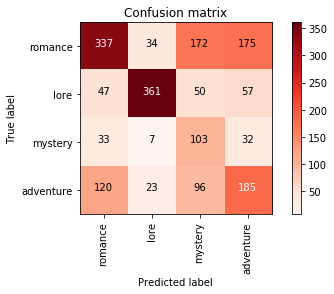

In [44]:

y_pred = forest_pipe2.predict(X_test_tfidf)
matrix = metrics.confusion_matrix(y_pred, y_test_tfidf)
labels = y_test_tfidf.unique()

plot_confusion_matrix(matrix, labels)

A quick recap of what I’ve done:

I decided to use the Brown corpus because of the multitude of categories and also ease of access. I started by collecting the sentences from each category into variables and checking their length. I chose to drop the science fiction category because of its size difference. Next, I joined my sentences together. They were lists of words instead of a single string. I then stripped out the punctuation, and collected each sentence into a data frame, labeling each row with the coordinating category. Next, I used a small function to pull the 200 most common words out of each category and created a set of common words for my corpus. With the sentences and common words, I then made a feature set of the word count for each sentence. 

I then turned my attention to making a term frequency-inverse document frequency feature set. For this feature set, I pulled in the raw data for each category. I then figured out the length for each after splitting it into paragraphs and recorded where in the data frame each would fall. 

Unfortunately, I had to wait to set up the pipeline until after I’d vectorized the paragraphs so I could correctly label each one. Once the category labels were set, I used make_pipeline from the SKLearn module to set up two pipelines. Both reduce the feature space down to 200, but one then feeds into a RandomForestClassifier and the other into a LogisticRegression. 

The first model I ran was random forest using the word count feature set. The feature set was very over fit for the training data, and returned a score barely better than chance for the test data. The cross validated scores support and reinforce the low test score. The logistic regression did a fair bit better than the random forest. The training scores and test scores were much closer together for the logistic regression, and the cross validated scores were very close. 

With both models run, I decided to try to improve the Random Forest classifier. I changed the number of ‘trees’ from the default 10 up to 100 and saw a 5% increase in my accuracy. 